# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [4]:
# https://tech.yandex.ru/disk/poligon/#!//v1/disk/public/resources/GetPublicResourceDownloadLink
!wget "https://downloader.disk.yandex.ru/disk/250287ddcf317a20c7d38336638b1451e10cb4e2b66a327ebc9af7ff8e320607/5cd0296e/Uu4oBB1ewGKwo8U0AKzFTUfelwBkoP2_hjzzsAq_c8-Pst8l9aofCapbQ0T5oOkQ767xOWLGu4Ky1pqKIwbMqw%3D%3D?uid=0&filename=Train_rev1.zip&disposition=attachment&hash=HtaQxsITuo98H7dTSaF7iY54Uoau4VmL91Q0%2BK6ki0o%3D%3A&limit=0&content_type=application%2Fzip&fsize=128356352&hid=f21d691c2ece2847cb6fd3ad5f053496&media_type=compressed&tknv=v2" -O Train_rev1.zip
!unzip Train_rev1.zip

--2019-05-06 08:33:14--  https://downloader.disk.yandex.ru/disk/250287ddcf317a20c7d38336638b1451e10cb4e2b66a327ebc9af7ff8e320607/5cd0296e/Uu4oBB1ewGKwo8U0AKzFTUfelwBkoP2_hjzzsAq_c8-Pst8l9aofCapbQ0T5oOkQ767xOWLGu4Ky1pqKIwbMqw%3D%3D?uid=0&filename=Train_rev1.zip&disposition=attachment&hash=HtaQxsITuo98H7dTSaF7iY54Uoau4VmL91Q0%2BK6ki0o%3D%3A&limit=0&content_type=application%2Fzip&fsize=128356352&hid=f21d691c2ece2847cb6fd3ad5f053496&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://s49vla.storage.yandex.net/rdisk/250287ddcf317a20c7d38336638b1451e10cb4e2b66a327ebc9af7ff8e320607/5cd0296e/Uu4oBB1ewGKwo8U0AKzFTUfelwBkoP2_hjzzsAq_c8-Pst8l9aofCapbQ0T5oOkQ767xOWLGu4Ky1pqKIwbMqw==?uid=0&filename=Train_rev1.zip&disposition=attachment&hash=HtaQxsI

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [6]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

125831    JOB DESCRIPTION: Inspection Test Engineer REPO...
111091    Perfect role for a passionate retail marketer;...
152580    This highly respected international law firm a...
Name: FullDescription, dtype: object

In [7]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
182973,71619487,Vocational Instructor of Electrical Engineering,A Technical Training provider is looking for a...,"North Yorkshire, North West",North Ewster,NaN,permanent,NaN,Teaching Jobs,26179 per annum,26179,jobs.telegraph.co.uk,10.172751
77404,69010979,Managing Dispensing Optician,My client is a busy market town Opticians base...,"Leeds, West Yorkshire",Leeds,NaN,permanent,Zest Business Group,Healthcare & Nursing Jobs,18000 - 24000/annum Bonus,21000,cv-library.co.uk,9.952325
12098,66543451,Registered Nurse (Adult),Willow Brook Nursing and Residential Home Abou...,Nottingham,Nottingham,part_time,NaN,Bupa Care Services,Healthcare & Nursing Jobs,12.00 per hour,23040,Jobcentre Plus,10.045031


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [8]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    data[col].apply(lambda l: token_counts.update(l.split()))

In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

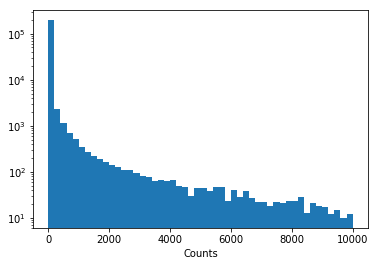

In [13]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [t for t, c in token_counts.items() if c >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [15]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = dict(map(reversed, enumerate(tokens)))

In [17]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [0]:
generate_batch(data_train, 3, max_len=10)

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
       
        emb_size = 64
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        
        self.conv1_1 = nn.Conv1d(emb_size, out_size, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv1d(emb_size, out_size, kernel_size=5, padding=2)
        self.lstm = nn.LSTM(emb_size, 32, num_layers=2, bidirectional=True)
        
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(2 * out_size + 64, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h_t = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        l = torch.transpose(self.lstm(h)[0], 1, 2)
        
        o = torch.cat([self.conv1_1(h_t), self.conv1_2(h_t), l], dim=1)
        o = self.pool1(o)
        o = F.relu(o)
        o = self.dense(o)
        
        return o

In [28]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        emb_size = 64
        
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        
        self.conv1_1 = nn.Conv1d(emb_size, out_size, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv1d(emb_size, out_size, kernel_size=3, dilation=2, padding=2)
        self.lstm = nn.LSTM(emb_size, 32, num_layers=2, bidirectional=True)
        self.pool = GlobalMaxPooling()
        self.dense = nn.Linear(2 * out_size + 64, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h_t = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        l = torch.transpose(self.lstm(h)[0], 1, 2)
        
        o = torch.cat([self.conv1_1(h_t), self.conv1_2(h_t), l], dim=1)
        o = self.pool(o)
        o = F.relu(o)
        o = self.dense(o)
        
        return o

In [30]:
desc_encoder = DescEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        title_enc_out_size = 64
        desc_enc_out_size = 128
        cat_enc_out_size = 256
        combined_enc_out_size = sum([title_enc_out_size, desc_enc_out_size, cat_enc_out_size])
        
        self.title_encoder = TitleEncoder(out_size=title_enc_out_size)
        self.desc_encoder = DescEncoder(out_size=desc_enc_out_size)
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, cat_enc_out_size),
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Sequential(
            nn.Linear(combined_enc_out_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 1),
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.output(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [0]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 20
max_len = 100
batch_size = 128
batches_per_epoch = 100

In [0]:
model = FullNetwork()

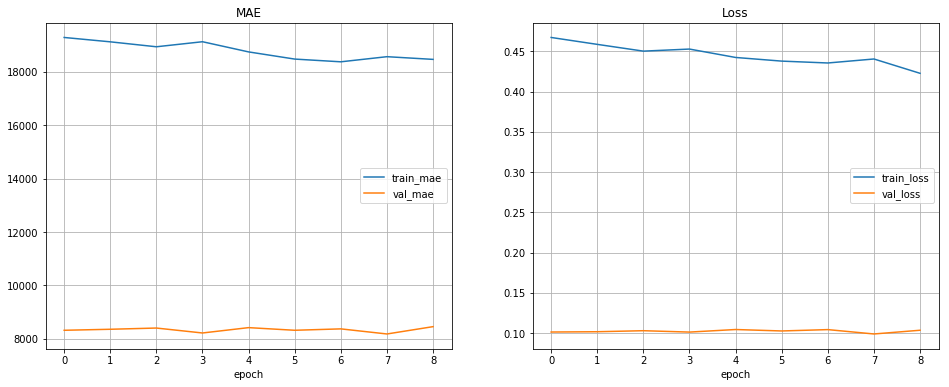

train loss:		0.422723
train mae:		18468.77
val loss:		0.103438
val mae:		8456.63
Training:	10


KeyboardInterrupt: ignored

In [71]:
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8, weight_decay=1e-4)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

history = {
    'train_loss': [],
    'train_mae': [],
    'val_loss': [],
    'val_mae': [],
}

def plot_history(ax, name):
    ax.plot(np.arange(len(history[name])), history[name], label=name)

model = model.cuda()
for epoch_i in range(num_epochs):
    
    print("Training:\t%i" % (epoch_i + 1))
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, batch_size=batch_size, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy() # [0]
        train_mae += compute_mae(reference, prediction).cpu().data.numpy() # [0]
        train_batches += 1
        
    history["train_loss"].append(train_loss / train_batches)
    history["train_mae"].append(train_mae / train_batches)
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, batch_size=128, max_batches=100, shuffle=True):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy() # [0]
        val_mae += compute_mae(reference, prediction).cpu().data.numpy() # [0]
        val_batches += 1
        
    history["val_loss"].append(val_loss / val_batches)
    history["val_mae"].append(val_mae / val_batches)
    
    clear_output()
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.set_title("MAE")
    ax1.set_xlabel("epoch")
    plot_history(ax1, "train_mae")
    plot_history(ax1, "val_mae")
    ax1.legend(loc='best')
    ax1.grid()
    
    ax2.set_title("Loss")
    ax2.set_xlabel("epoch")
    plot_history(ax2, "train_loss")
    plot_history(ax2, "val_loss")
    ax2.legend(loc='best')
    ax2.grid()
    
    plt.show()
    
    print("train loss:\t\t{:.6f}".format(history["train_loss"][-1]))
    print("train mae:\t\t{:.2f}".format(history["train_mae"][-1]))
    print("val loss:\t\t{:.6f}".format(history["val_loss"][-1]))
    print("val mae:\t\t{:.2f}".format(history["val_mae"][-1]))

In [72]:
print("Final eval:")
model = model.cuda()
model.train(False)
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.cpu().data.numpy() # [0]
    val_mae += compute_mae(reference, prediction).cpu().data.numpy() # [0]
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


	Loss:	0.10183
	MAE:	8306.31570





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    model = model.cpu()
    model.train(False)
    """ Computes the effect each word had on model predictions """
    s = {}
    for col in text_columns:
        s[col] = as_matrix(np.array(sample[col]).reshape(1), max_len).reshape(1, -1)
    
    s["Categorical"] = categorical_vectorizer.transform(sample[categorical_columns].to_dict())
    
    def get_col(c, i):
        if c != col_name:
            return s[c]
        sc = s[c].copy()
        sc[0, i] = token_to_id[UNK]
        return sc
    
    # compute model prediction on sample (scalar float log-salary)
    cat_features = torch.tensor(s["Categorical"], dtype=torch.float32)
    
    title_ix = torch.tensor(s["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(s["FullDescription"], dtype=torch.int64)
    
    baseline_pred = model(title_ix, desc_ix, cat_features).data.numpy()[0]
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = []
    for i in range(s[col_name].size):
        title_ix = torch.tensor(get_col("Title", i), dtype=torch.int64)
        desc_ix = torch.tensor(get_col("FullDescription", i), dtype=torch.int64)
        p = model(title_ix, desc_ix, cat_features).data.numpy()[0]
        predictions_without_word.append(p)
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    return baseline_pred, [(tokens[token], score_differences[i]) for i, token in enumerate(s[col_name][0])]

In [100]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

_, tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             71866652
Title                 corporate & trust fundraising manager dementia...
FullDescription       our client is a charity that offers a wide var...
LocationRaw                                              Greater London
LocationNormalized                                               London
ContractType                                                  full_time
ContractTime                                                  permanent
Company                                                             CHM
Category                                                  Teaching Jobs
SalaryRaw                                        Circa 38,000 per annum
SalaryNormalized                                                  38000
SourceName                                          jobs.guardian.co.uk
Log1pSalary                                                     10.5454
Name: 201322, dtype: object
[('corporate', -0.0090379715)

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [102]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
salary, tokens_and_weights = explain(model, sample, "Title")

print("Salary (gbp):", sample["SalaryNormalized"])
print("Predicted salary (gbp)", np.exp(salary) - 1)

draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');
print(tokens_and_weights)

_, tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);
print(tokens_and_weights)

sample

Index: 50250
Salary (gbp): 60000
Predicted salary (gbp) 37097.74609375


ux developer / architect

[('ux', -0.0757103), ('developer', -0.10952854), ('/', 0.11020851), ('architect', -0.09571171)]


fpsg are recruiting for a leading brand within the consultancy marketplace for a ux developer / architect for their digital practice . the ux developer / architect will be tasked to lead the creative experience , through close collaboration with clients , their agencies and interested stakeholder groups . the role holder will be technically savvy and handson team players , with a good understanding of delivery processes , industry tools and current technologies , and a history of successful enterprise scale delivery across multiple devices . essential excellent client relationship and engagement skills : you must be able to

[('fpsg', 0.002155304), ('are', 0.0003566742), ('recruiting', -0.010687828), ('for', -0.0032167435), ('a', 0.015557289), ('leading', 0.012591362), ('brand', 0.0127363205), ('within', 0.0021047592), ('the', 8.583069e-06), ('consultancy', 0.022927284), ('marketplace', -0.0040388107), ('for', 0.019189835), ('a', 0.020301819), ('ux', -0.0019416809), ('developer', 0.033866882), ('/', -0.001982689), ('architect', 0.0054130554), ('for', 0.00089359283), ('their', 0.0047798157), ('digital', -0.0082502365), ('practice', -0.0035142899), ('.', -0.0034322739), ('the', 0.022919655), ('ux', 0.02076149), ('developer', 0.038916588), ('/', 0.013689995), ('architect', -0.0068130493), ('will', 0.01011467), ('be', -0.01063633), ('tasked', 0.00026988983), ('to', 0.0033464432), ('lead', -0.0018978119), ('the', -0.005268097), ('creative', 0.008419991), ('experience', 0.0037136078), (',', 0.0758028), ('through', -0.00081920624), ('close', 0.037356377), ('collaboration', -0.0027132034), ('with', 0.036003113), (

Id                                                             68630923
Title                                          ux developer / architect
FullDescription       fpsg are recruiting for a leading brand within...
LocationRaw                                     City of London - London
LocationNormalized                                             The City
ContractType                                                  full_time
ContractTime                                                  permanent
Company                                                       CVbrowser
Category                                                        IT Jobs
SalaryRaw                                                 45000 - 75000
SalaryNormalized                                                  60000
SourceName                                                cvbrowser.com
Log1pSalary                                                     11.0021
Name: 50250, dtype: object

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...
 
- First of all I tried simple models (dense + bn + relu) and even use the same encoder for title and description.  
I got MAE ~12k.

- After checking the predictions of the model I got that the model doen't pay enough attention to description and focuses on title.

- Adding parallel conv layer with dilaition = 2 helped me to gain MAE ~10k, but the model started overfitting.

- Dropout(0.5) and adding weight_decay to the optimizer helped to gain MAE ~8.5k on validation (BN was used by default).

- Increasing batch size on train helped to gain MAE ~8.2k.
